In [210]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [211]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [212]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [213]:
# create engine to hawaii.sqlite
path = 'Resources/hawaii.sqlite'
engine = create_engine(f'sqlite:///{path}')

In [214]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [215]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [216]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [217]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [219]:
# Find the most recent date in the data set.
max_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()['date']
max_date = dt.datetime.strptime(max_date_str, '%Y-%m-%d')
print(max_date)

2017-08-23 00:00:00


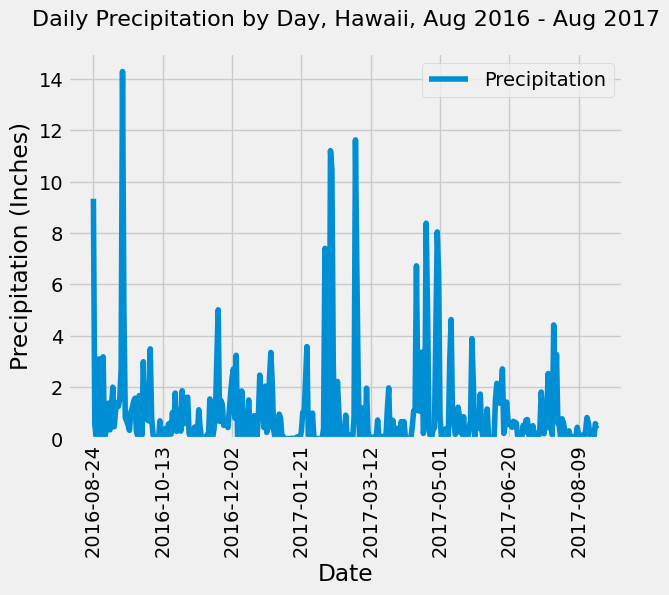

In [238]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = max_date - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
yearly_prcp = session.query(Measurement.date, func.sum(Measurement.prcp)).\
    group_by(Measurement.date).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= start_date).\
    order_by(Measurement.date).all()
yearly_prcp

# Save the query results as a Pandas DataFrame and set the index to the date column
yearly_prcp_df = pd.DataFrame(yearly_prcp, columns=['Date', 'Precipitation'])
yearly_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
yearly_prcp_df.set_index('Date', inplace=True, drop=True)
yearly_prcp_df.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.ylim(0,15)
plt.title('Daily Precipitation by Day, Hawaii, Aug 2016 - Aug 2017', size=16, y=1.05)
plt.ylabel('Precipitation (Inches)')
plt.savefig('Images/precipitation.png', bbox_inches='tight')
plt.show()


In [221]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yearly_prcp_not_grouped = session.query(Measurement.date, Measurement.prcp.label('Precipitation')).\
    filter(func.strftime('%Y-%m-%d', Measurement.date) >= start_date).all()

yearly_prcp_not_grouped_df = pd.DataFrame(yearly_prcp_not_grouped)
yearly_prcp_not_grouped_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [222]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station)
print(f'There were {stations.count()} stations at which precipitation data was taken in Hawaii.')

There were 9 stations at which precipitation data was taken in Hawaii.


In [223]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_info = []

for x in stations:
    
    obs = session.query(Measurement).\
        filter(Measurement.station == x.station).count()
    
    dict = {
        'station': x.station,
        'observations': obs
    }
    
    station_info.append(dict)

station_info_df = pd.DataFrame(station_info).sort_values('observations', ascending=False).reset_index(drop=True)
most_active_station = station_info_df.iloc[0,0]
station_info_df
    


,station,observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [224]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_data = session.query(Measurement.prcp.label('Precipitation')).\
    filter(Measurement.station == most_active_station).all()

active_station_data_df = pd.DataFrame(active_station_data).agg({
    'Precipitation': {'min', 'max', 'mean'}
})
active_station_data_df


,Precipitation
mean,0.212352
max,9.640000
min,0.000000


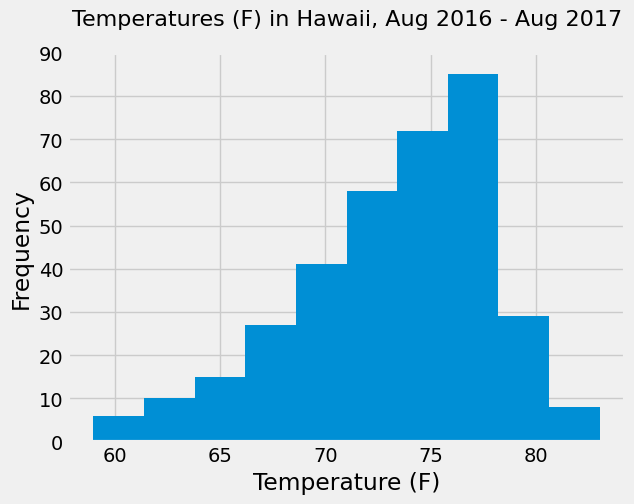

In [225]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_data_year = session.query(Measurement.date.label('Date'), Measurement.tobs.label('Temperature')).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

active_station_data_year_df = pd.DataFrame(active_station_data_year)

# plot as histogram
active_station_data_year_df.plot.hist(legend=None)
plt.title('Temperatures (F) in Hawaii, Aug 2016 - Aug 2017', size=16, y=1.05)
plt.xlabel('Temperature (F)')
plt.ylim(0,90)
plt.savefig('Images/station-histogram.png', bbox_inches='tight')
plt.show()


# Close session

In [ ]:
# Close Session
session.close()